In [1]:
import pandas as pd
import numpy as np

# step 1: load all GALAH targets
targets = pd.read_csv('./GALAH_targets-result.csv') # all GALAH targets
binaries = pd.read_csv('./GALAH_binaries_dr3-result.csv') # all GALAH binaries from Traven et. al 2020

# step 3: filters to remove logg<4, select ones with RVS spectra, 
# and require non_single_star=0 for single star sample
# also remove nan values for vbroad
targets_filt = targets.query('logg_gspphot>4 & non_single_star==0 & has_rvs==True')
print(len(targets), 'GALAH targets from Gaia xmatch')
print(len(targets_filt), ' remaining after logg, non_single_star, has_rvs cuts')
targets_filt = targets_filt[~np.isnan(targets_filt.vbroad.to_numpy())]
print(len(targets_filt), ' remaining after requiring finite vbroad')

# step 4: remove binaries from full target list
binaries_source_ids = binaries.source_id.to_numpy()
binary_idx = []
for i in range(len(targets_filt)):
    row = targets_filt.iloc[i]
    if row.source_id in binaries_source_ids:
        #print(i, end=',')
        binary_idx.append(i)
targets_filt_binaries_removed = targets_filt.drop(targets_filt.index[binary_idx])
print(len(targets_filt_binaries_removed), ' remaining after removing binaries from Traven 2020')
print('')

# step 4: filters to remove logg<4, select ones with RVS spectra, 
# and require non_single_star=1 for binary sample
# also remove nan values for vborad
binaries_filt = binaries.query('logg_gspphot>4 & non_single_star==1 & has_rvs==True')
print(len(binaries), 'GALAH binaries from Gaia xmatch')
print(len(binaries_filt), ' binaries after logg, non_single_star, has_rvs cuts')
binaries_filt = binaries_filt[~np.isnan(binaries_filt.vbroad.to_numpy())]
print(len(binaries_filt), ' remaining after requiring finite vbroad')

678312 GALAH targets from Gaia xmatch
84859  remaining after logg, non_single_star, has_rvs cuts
27684  remaining after requiring finite vbroad
26265  remaining after removing binaries from Traven 2020

13271 GALAH binaries from Gaia xmatch
92  binaries after logg, non_single_star, has_rvs cuts
54  remaining after requiring finite vbroad


Text(0.5, 0, 'bp_rp')

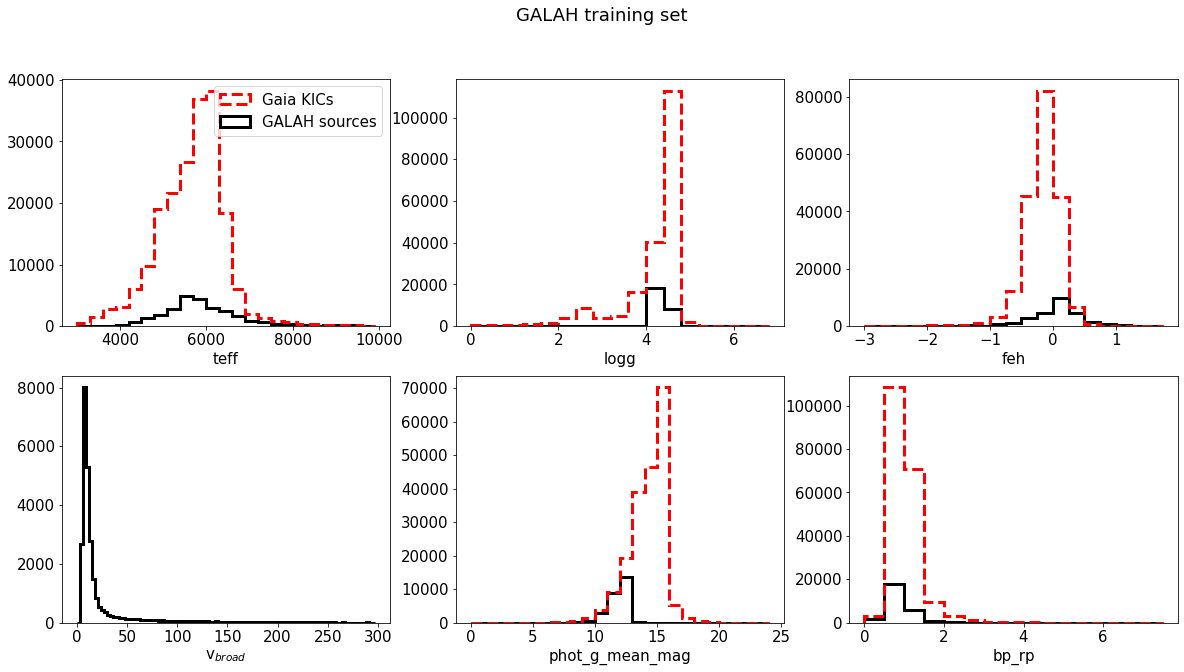

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.size']=15
plt.figure(figsize=(20,10))
plt.suptitle('GALAH training set')

from astropy.table import Table
KIC_data = Table.read('./kepler_dr3_good.fits', format='fits').to_pandas()
GALAH_data = targets_filt_binaries_removed

Teff_bins = np.arange(3000,10000,300)
logg_bins = np.arange(0,7,0.4)
fe_h_bins = np.arange(-3,2,0.25)
gmag_bins = np.arange(0,25,1)
bprp_bins = np.arange(0,8,0.5)
vbroad_bins = np.arange(0,300,3)

plt.subplot(231)
plt.hist(KIC_data.teff, bins=Teff_bins, label='Gaia KICs',
         histtype='step', ls='--', lw=3, color='r')
plt.hist(GALAH_data.teff_gspphot, bins=Teff_bins, label='GALAH sources', 
         histtype='step', lw=3, color='k', zorder=0)
plt.xlabel('teff');plt.legend()
plt.subplot(232)
plt.hist(KIC_data.logg, bins=logg_bins, 
         histtype='step', ls='--', lw=3, color='r')
plt.hist(GALAH_data.logg_gspphot, bins=logg_bins, 
         histtype='step', lw=3, color='k', zorder=0)
plt.xlabel('logg')
plt.subplot(233)
plt.hist(KIC_data.feh, bins=fe_h_bins, 
         histtype='step', ls='--', lw=3, color='r')
plt.hist(GALAH_data.rv_template_fe_h, bins=fe_h_bins, 
         histtype='step', lw=3, color='k', zorder=0)
plt.xlabel('feh')

plt.subplot(234)
plt.hist(GALAH_data.vbroad, bins=vbroad_bins, 
         histtype='step', lw=3, color='k', zorder=0)
plt.xlabel(r'v$_{broad}$')

plt.subplot(235)
plt.hist(KIC_data.phot_g_mean_mag, bins=gmag_bins, 
         histtype='step', ls='--', lw=3, color='r')
plt.hist(GALAH_data.phot_g_mean_mag, bins=gmag_bins,
         histtype='step', lw=3, color='k', zorder=0)
plt.xlabel('phot_g_mean_mag')

plt.subplot(236)
plt.hist(KIC_data.bp_rp, bins=bprp_bins,
         histtype='step', ls='--', lw=3, color='r')
plt.hist(GALAH_data.phot_bp_mean_mag-GALAH_data.phot_rp_mean_mag, bins=bprp_bins,
         histtype='step', lw=3, color='k', zorder=0)
plt.xlabel('bp_rp')

Text(0, 0.5, 'normalized occurrence')

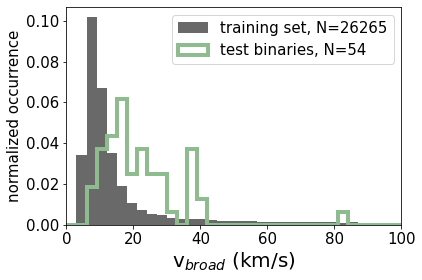

In [3]:
# plot of vbroad for singles, binaries

training_set = targets_filt_binaries_removed
test_binaries = binaries_filt
plt.hist(training_set.vbroad, bins=vbroad_bins, density=True, color='dimgrey',
        label='training set, N={}'.format(len(targets_filt_binaries_removed)))
plt.hist(test_binaries.vbroad, bins=vbroad_bins, density=True, color='darkseagreen', 
         histtype='step',lw=4, label='test binaries, N={}'.format(len(binaries_filt)))
plt.xlim(0,100);plt.legend()
plt.xlabel(r'v$_{broad}$ (km/s)',fontsize=20)
plt.ylabel('normalized occurrence')

(15.0, 27.0)

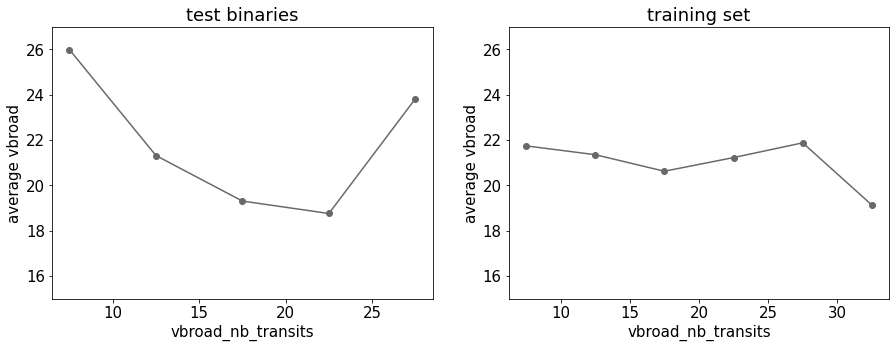

In [4]:
bin_edges = [0,5,10,15,20,25,30,35]
nb_transits_avg = []
vbroad_avg_binaries = [];vbroad_avg_singles = []
for i in range(len(bin_edges)-1):
    low = str(bin_edges[i])
    high = str(bin_edges[i+1])
    nb_transits_avg.append(np.mean([int(low),int(high)]))
    query_str = 'vbroad_nb_transits >= '+low+' & vbroad_nb_transits < '+high
    df_subset_binaries = test_binaries.query(query_str)
    df_subset_singles = training_set.query(query_str)
    vbroad_avg_binaries.append(np.mean(df_subset_binaries.vbroad))
    vbroad_avg_singles.append(np.mean(df_subset_singles.vbroad))

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('test binaries')
plt.plot(nb_transits_avg, vbroad_avg_binaries, '-', color='dimgrey')
plt.plot(nb_transits_avg, vbroad_avg_binaries, 'o', color='dimgrey')
plt.xlabel('vbroad_nb_transits');plt.ylabel('average vbroad')
plt.ylim(15,27)
plt.subplot(122)
plt.title('training set')
plt.plot(nb_transits_avg, vbroad_avg_singles, '-', color='dimgrey')
plt.plot(nb_transits_avg, vbroad_avg_singles, 'o', color='dimgrey')
plt.xlabel('vbroad_nb_transits');plt.ylabel('average vbroad')
plt.ylim(15,27)

In [5]:
# next: save training set and test binaries to dataframes.
# then I'll have to split up the training set into actual training ones and test ones
# I think I only need like 1000 for a training set.

# Ness: trained on training set of separately determined stars (cluster members),
# test on the rest of the APOGEE spectra
# El-Badry:
# training set is random sample of 2000 main sequence apogee stars
# made sure they reasonably spanned label space
# Rice: 3 different 80%/20% test splits,
# but it's unclear if they ended up just using 1? I think they did

In [6]:
training_column_names = {"designation": "edr3_designation", 
                 "designation.1": "dr3_designation", 
                 "source_id":"dr3_source_id"}
training_set.rename(columns=training_column_names, inplace=True)

binaries_column_names = {"source_id": "dr3_source_id"} 
test_binaries.pop('gaiadr2')
test_binaries.rename(columns=training_column_names, inplace=True)


In [13]:
# save these to dataframes
training_set.to_csv('GALAH_training_set.csv', index=False)
test_binaries.to_csv('GALAH_test_binaries.csv', index=False)